## California Wildfire Precidtion

This challenge aims to provide answer for those questions:

1. What is the distribution of wildfires in California?
2. Is there any trend in the wildfire frequency and severity (acres burned)?
3. Is there any trend in climate?
4. What are the major factors affecting frequency and severity of wildfires?
5. Can you build models that predicts annual/monthly (1) frequency wildfires, (2) severity of wildfires (by acres burned)?


weather data (from NOAA): https://drive.google.com/file/d/1AFlb7WMZ-9rCL5FfM9Ah5VCjE1Ml7rli/view?usp=sharing
wildfire burn data: 
1. https://wfdss.usgs.gov/wfdss/WFDSS_Data_Downloads.shtml
2. https://www.kaggle.com/rtatman/188-million-us-wildfires/metadata
3. https://mtbs.gov/direct-download

Prerequisites: pandas, numpy, seaborn, matplotlib, geopandas and sklearn

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
import geopandas as gpd
import sqlite3

### PART 0. 
Examine the datasets before we try to solve the questions

#### PART 0.1
We first evaluated the FPA_FOD_20170508.sqlite database file, which includes 24-year, 1.88 million wildfire data in the U.S. The detailed information can be found at: https://www.kaggle.com/rtatman/188-million-us-wildfires. <br>
Here we only query a few "most important" columns based on the information provided by the website, based on some domain knowledges. At the end, we have some sense of the counts and ranges of data in the file. 

In [2]:
def read_sqlitedate(file_name, table_name, columns, condition):
    """
    This function read the sqlite database and print some statistics
    columns: only query the "most important" columns
    """
    con = sqlite3.connect(file_name)
    df = pd.read_sql_query("SELECT " + columns + " FROM " + table_name + " WHERE " + condition, con)
    print(list(df.columns))
    print(df.describe())
    return df

In [3]:
df_fpa = read_sqlitedate("FPA_FOD_20170508.sqlite", "Fires", "FPA_ID,FIRE_NAME,FIRE_YEAR,DISCOVERY_DOY,CONT_DOY,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE,FIPS_NAME", "STATE='CA'")

['FPA_ID', 'FIRE_NAME', 'FIRE_YEAR', 'DISCOVERY_DOY', 'CONT_DOY', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE', 'STATE', 'FIPS_NAME']
           FIRE_YEAR  DISCOVERY_DOY      CONT_DOY      FIRE_SIZE  \
count  189550.000000  189550.000000  91908.000000  189550.000000   
mean     2003.118275     201.594571    203.607727      67.242725   
std         7.007634      65.936299     65.127623    2029.960435   
min      1992.000000       1.000000      1.000000       0.001000   
25%      1997.000000     164.000000    169.000000       0.100000   
50%      2003.000000     202.000000    206.000000       0.250000   
75%      2009.000000     245.000000    246.000000       1.000000   
max      2015.000000     366.000000    366.000000  315578.800000   

            LATITUDE      LONGITUDE  
count  189550.000000  189550.000000  
mean       37.434167    -120.182292  
std         2.591567       2.155615  
min        32.537406    -124.402883  
25%        35.177688    -121.721944  
50%        37.

#### Part 0.2
Then we evaluat the two MTBS.gov shapefiles, which seem also include both fire occurence and burn area data.

In [4]:
def read_shapefile(path, file_name):
    """
    This function read the shapefile using geopandas and print some statistics
    """
    shape = gpd.read_file(path+file_name)
    print(list(shape.columns))
    print(shape.describe())
    return shape

In [5]:
def clip_and_plot(shape, ca):
    """
    This function clip the wildfire shapefile with the state shapefile, then return the clipped shapefile
    """
    ca_shape = gpd.clip(shape, ca)
    print(list(ca_shape.columns))
    print(ca_shape.describe())
    ax = ca.plot(edgecolor='k', facecolor='none', figsize=(15, 10))
    ca.plot(ax=ax)
    ca_shape.plot(ax=ax, color='red')
    return ca_shape

In [6]:
burn = read_shapefile("./S_USA.MTBS_BURN_AREA_BOUNDARY/","S_USA.MTBS_BURN_AREA_BOUNDARY.shp")
occurrence = read_shapefile("./S_USA.MTBS_FIRE_OCCURRENCE_PT/","S_USA.MTBS_FIRE_OCCURRENCE_PT.shp")

['FIRE_ID', 'FIRE_NAME', 'YEAR', 'STARTMONTH', 'STARTDAY', 'FIRE_TYPE', 'ACRES', 'SHAPE_AREA', 'SHAPE_LEN', 'geometry']
               YEAR    STARTMONTH     STARTDAY         ACRES    SHAPE_AREA  \
count  22969.000000  22969.000000  22969.00000  2.296900e+04  22969.000000   
mean    2004.841003      5.743524     15.17602  7.558648e+03      0.003718   
std        9.361582      2.677844      8.83953  2.692651e+04      0.014986   
min     1984.000000      1.000000      1.00000  4.870000e+02      0.000177   
25%     1999.000000      4.000000      8.00000  1.252000e+03      0.000514   
50%     2007.000000      6.000000     15.00000  2.118000e+03      0.000884   
75%     2012.000000      8.000000     23.00000  4.774000e+03      0.002060   
max     2017.000000     12.000000     31.00000  1.183539e+06      0.493442   

          SHAPE_LEN  
count  22969.000000  
mean       0.383528  
std        1.402733  
min        0.055046  
25%        0.138237  
50%        0.204867  
75%        0.357601  
m

In [7]:
usa = read_shapefile("./CA_shape/","cb_2018_us_state_500k.shp")
ca = usa[usa['STUSPS'] == 'CA'] # We subset California shapefile from the USA shapefile since our analysis focus on California

['STATEFP', 'STATENS', 'AFFGEOID', 'GEOID', 'STUSPS', 'NAME', 'LSAD', 'ALAND', 'AWATER', 'geometry']
              ALAND        AWATER
count  5.600000e+01  5.600000e+01
mean   1.635689e+11  1.247434e+10
std    2.173781e+11  3.504545e+10
min    1.583404e+08  1.868720e+07
25%    2.483187e+10  1.503499e+09
50%    1.285489e+11  3.707035e+09
75%    2.007747e+11  8.963612e+09
max    1.478840e+12  2.454816e+11


['FIRE_ID', 'FIRE_NAME', 'YEAR', 'STARTMONTH', 'STARTDAY', 'FIRE_TYPE', 'ACRES', 'SHAPE_AREA', 'SHAPE_LEN', 'geometry']
              YEAR   STARTMONTH     STARTDAY          ACRES   SHAPE_AREA  \
count  1733.000000  1733.000000  1733.000000    1733.000000  1733.000000   
mean   2000.323716     7.428736    16.514714    9712.014232     0.004006   
std       9.851888     1.705251     9.269723   25444.012459     0.010610   
min    1984.000000     1.000000     1.000000    1001.000000     0.000395   
25%    1992.000000     6.000000     9.000000    1574.000000     0.000644   
50%    2000.000000     7.000000    17.000000    2791.000000     0.001142   
75%    2008.000000     8.000000    25.000000    6847.000000     0.002824   
max    2017.000000    12.000000    31.000000  495308.000000     0.218826   

         SHAPE_LEN  
count  1733.000000  
mean      0.360684  
std       0.420667  
min       0.084841  
25%       0.152655  
50%       0.217111  
75%       0.379456  
max       4.567744  


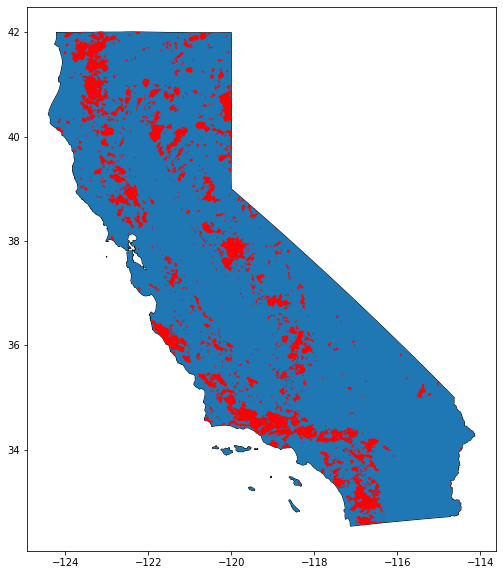

In [8]:
ca_burn = clip_and_plot(burn, ca)

['FIRE_ID', 'FIRE_NAME', 'ASMNT_TYPE', 'PRE_ID', 'POST_ID', 'FIRE_TYPE', 'NODATA_THR', 'GREENNESS_', 'LOW_THRESH', 'MODERATE_T', 'HIGH_THRES', 'IG_DATE', 'LATITUDE', 'LONGITUDE', 'ACRES', 'geometry']
            POST_ID   NODATA_THR   GREENNESS_   LOW_THRESH   MODERATE_T  \
count  1.705000e+03  1705.000000  1705.000000  1705.000000  1705.000000   
mean   5.641986e+13 -1487.655132  -716.051026    85.600000   482.209384   
std    1.139346e+13  2102.740605  2293.104106    55.637066  2781.473006   
min    4.044031e+13 -9999.000000 -9999.000000  -210.000000 -9999.000000   
25%    5.042034e+13  -970.000000  -150.000000    50.000000   230.000000   
50%    5.043035e+13  -970.000000  -150.000000    80.000000   287.000000   
75%    5.046031e+13  -970.000000  -150.000000   120.000000   339.000000   
max    8.046032e+13     0.000000     0.000000   450.000000  9999.000000   

        HIGH_THRES     LATITUDE    LONGITUDE          ACRES  
count  1705.000000  1705.000000  1705.000000    1705.000000  


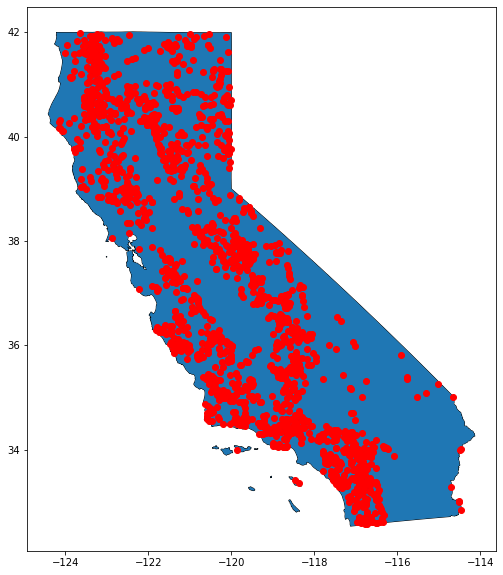

In [9]:
ca_occurrence = clip_and_plot(occurrence, ca)

There are 189550 wildfire events (1992-2015) documented in "FPA_FOD_20170508.sqlite", however, only 1733 events (1984-2017) in MTSB datasets (in California). The differences are significant. After looking into the dataset statistics more carefully, the mininum fire size in MTSB shapefiles is 500 acres, but is 0.001 in "FPA_FOD_20170508.sqlite". In other word, "FPA_FOD_20170508.sqlite" documented all wildfire events, while MTSB only includes the larger wildfire events. 

Just try to query the "FPA_FOD_20170508.sqlite" with the condition of "FIRE_SIZE>=500" to examine if they have similar number of wildfire events. The count is 1717. We do not expect the numbers are exactly the same because they are over different periods and collected by different sources, but they are similar.  

In [10]:
df = read_sqlitedate("FPA_FOD_20170508.sqlite", "Fires", "FIRE_NAME,FIRE_YEAR,DISCOVERY_DOY,CONT_DOY,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE,FIPS_NAME", "STATE='CA' AND FIRE_SIZE>=500")

['FIRE_NAME', 'FIRE_YEAR', 'DISCOVERY_DOY', 'CONT_DOY', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE', 'STATE', 'FIPS_NAME']
         FIRE_YEAR  DISCOVERY_DOY     CONT_DOY      FIRE_SIZE     LATITUDE  \
count  1717.000000    1717.000000  1241.000000    1717.000000  1717.000000   
mean   2002.772277     205.993593   223.200645    6839.921124    37.094914   
std       6.719226      49.483633    55.125905   20218.006750     2.671879   
min    1992.000000       2.000000     7.000000     500.000000    32.560000   
25%    1996.000000     174.000000   188.000000     800.000000    34.686667   
50%    2003.000000     206.000000   224.000000    1500.000000    36.916944   
75%    2008.000000     236.000000   258.000000    4416.000000    39.591000   
max    2015.000000     361.000000   365.000000  315578.800000    41.988333   

         LONGITUDE  
count  1717.000000  
mean   -119.846034  
std       2.126340  
min    -124.073169  
25%    -121.439722  
50%    -119.966944  
75%    -118.316

#### PART 0.3
We also looked the climate datasets. Since the FPA datasets expands from 1992 to 2015, we only read weather dataset during the same period.  <br>
The definition of variables and their units can be found at: https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt 

In [11]:
def read_weather(year, path, file_name):
    """
    This function read one single weather_average_stats.csv file and process the datetime
    yymm is a column that will be used later
    """
    df = pd.read_csv(path+str(year)+file_name)
    df['date'] = pd.to_datetime(pd.to_datetime(year*100 + df["month"].round(2),format = "%Y%m"))
    df['yymm'] = df['date'].dt.to_period('M')
    df = df.set_index('date')
    return df

In [12]:
def read_all_weather(syear, eyear, path, file_name):
    """
    This function read all-year weather files by calling function read_weather and concatenate individual file
    Also output some statistics
    """
    weather = read_weather(1992, path, file_name)
    for year in range(1993,2016):
        df = read_weather(year, path, file_name)
        weather = pd.concat([weather, df]) 
    print(list(weather.columns))
    print(weather.describe())
    return weather

In [13]:
weather = read_all_weather(1992, 2016, './weather_data/', '_average_stats.csv')

['Lat', 'Lon', 'month', 'AWND', 'DAPR', 'EVAP', 'MDPR', 'MNPN', 'MXPN', 'PGTM', 'PRCP', 'SNOW', 'SNWD', 'TAVG', 'TMAX', 'TMIN', 'TOBS', 'WDFG', 'WDMV', 'WESD', 'WSFG', 'WT01', 'WT02', 'WT03', 'WT04', 'WT05', 'WT06', 'WT07', 'WT08', 'WT10', 'WT11', 'WT14', 'WT16', 'WT18', 'WT22', 'yymm', 'WT17', 'WT19', 'WT13', 'WT21', 'WV01', 'WV03', 'WV20', 'FMTM', 'WDF2', 'WDF5', 'WSF2', 'WSF5', 'TSUN', 'DASF', 'MDSF']
                Lat           Lon         month          AWND           DAPR  \
count  1.270080e+06  1.270080e+06  1.270080e+06  1.270080e+06  701190.000000   
mean   3.725034e+01 -1.196522e+02  6.500000e+00  2.991938e+01       5.612899   
std    2.591151e+00  2.519133e+00  3.452054e+00  1.103480e+01      10.381964   
min    3.260000e+01 -1.244000e+02  1.000000e+00  1.666667e+00       2.000000   
25%    3.510000e+01 -1.216000e+02  3.750000e+00  2.241935e+01       2.000000   
50%    3.700000e+01 -1.200000e+02  6.500000e+00  2.906452e+01       3.000000   
75%    3.950000e+01 -1.176000e+0

### PART 1. 
Q: What is the distribution of wildfires in California? <br>
Here, We try to answer both spatial (part 1.1) and temporal (part 1.2) distribution of wildfires in California. <br>
We used two MTSB shapefiles (read and processed in part 0.2) to describe the spatial distribution of wildfire events, and use the FPA dataset (read and processed in part 0.1) to describe temporal distribution of wildfire events, since it includes all wildfire events. 

#### PART 1.1
The spatial distribution is evaluated at county level (a CA county shapefile is used here, downloaded from https://data.ca.gov/dataset/ca-geographic-boundaries)

In [14]:
def shapefile_quality_check(df, col, value):
    """
    This function does some quality check on the shapefile, including the NULL/NAN values, and the value_counts for specific column
    Because not all datapoints in the shapefiles are wildfire, we need to remove them. 
    """
    print(df.isnull().sum())
    print(df[col].value_counts())
    df = df[df[col] == value]
    return df

In [15]:
def join_and_plot(data, county, type):
    """
    This function spatial-join the datafile and county shapefile and aggregate by different metrics, depending on the task given
    Occurrence is computed as the count of fire event in each county
    Burn area is computed as the sum of burn area of fire events in each county
    At the end it visualize the joined shapefile by barplot
    """    
    df = gpd.sjoin(data, county, op='within', how='left')
    if type == "occurrence":
        df = df[['FIRE_ID','NAME']].groupby("NAME").count().sort_values(by=['FIRE_ID'])
        df.rename(columns = {'FIRE_ID':'OCCURRENCE'}, inplace = True) 
    elif type == "area":
        df = df[['SHAPE_AREA','NAME']].groupby("NAME").sum().sort_values(by=['SHAPE_AREA'])
        df.rename(columns = {'SHAPE_AREA':'AREA'}, inplace = True) 
    else:
        print("Not implemented yet!")
    plot = df.plot.bar(figsize=(12,6))
    fig = plot.get_figure()
    fig.savefig("./Plots/counties_"+type+".png")

In [16]:
ca_counties = read_shapefile("CA_Counties/","CA_Counties_TIGER2016.shp")

['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD', 'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry']
              ALAND        AWATER
count  5.800000e+01  5.800000e+01
mean   6.956916e+09  3.528745e+08
std    8.034836e+09  4.988760e+08
min    1.214557e+08  4.555000e+06
25%    2.485251e+09  4.162416e+07
50%    3.978040e+09  1.475074e+08
75%    8.948226e+09  4.752120e+08
max    5.194812e+10  2.729815e+09


In [17]:
# Because the ca_counties coordinate system is different from occurences and burn area shapefiles, a crs conversion is needed
ca_counties = ca_counties.to_crs(occurrence.crs)

In [18]:
ca_occurrence_wf = shapefile_quality_check(ca_occurrence,'FIRE_TYPE','Wildfire')

FIRE_ID       0
FIRE_NAME     0
ASMNT_TYPE    0
PRE_ID        0
POST_ID       0
FIRE_TYPE     0
NODATA_THR    0
GREENNESS_    0
LOW_THRESH    0
MODERATE_T    0
HIGH_THRES    0
IG_DATE       0
LATITUDE      0
LONGITUDE     0
ACRES         0
geometry      0
dtype: int64
Wildfire                1508
Prescribed Fire          107
Unknown                   61
Wildland Fire Use         28
Out of Area Response       1
Name: FIRE_TYPE, dtype: int64


In [19]:
ca_burn_wf = shapefile_quality_check(ca_burn,'FIRE_TYPE','Wildfire')

FIRE_ID       0
FIRE_NAME     0
YEAR          0
STARTMONTH    0
STARTDAY      0
FIRE_TYPE     0
ACRES         0
SHAPE_AREA    0
SHAPE_LEN     0
geometry      0
dtype: int64
Wildfire                1535
Prescribed Fire          108
Unknown                   61
Wildland Fire Use         28
Out of Area Response       1
Name: FIRE_TYPE, dtype: int64


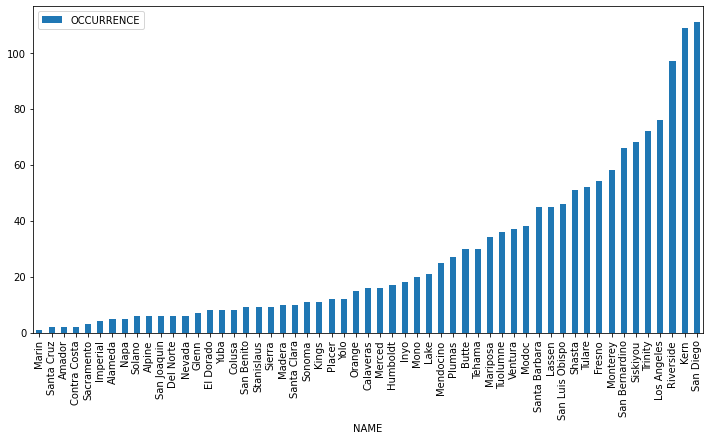

In [20]:
join_and_plot(ca_occurrence_wf, ca_counties,"occurrence")

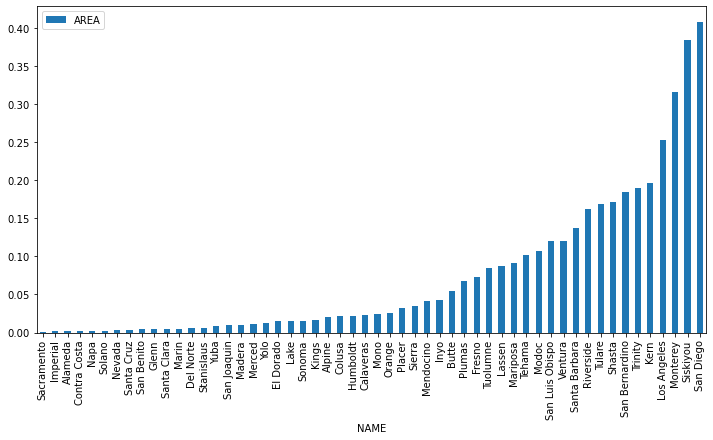

In [21]:
join_and_plot(ca_burn_wf, ca_counties,"area")

Analysis: Surprisingly, many couties (e.g., Napa and Sonoma) that has been widely reported for wildfire, do not have high occurrenecs and larger burn area from the shapefile. I guess the reasons might be 1) this datasets only include the wildfire before 2017, not recent years; 2) the counties rank top are much larger in area. We could consider to divide by the area of counties to get the "density" of wildfire events. 

#### PART 1.2
We examine temporal distribution by processing the datetime format of the wildfire first, and aggregate them into monthly average because 1) the weather data are monthly resolution; 2) there is no significant value to analyze them in daily temporal scale. <br>
Here, we aggregate the datasets within California to get a sense of "state-wide" wildfire distribution over time.

In [22]:
def processed_date(df):
    """
    This function process the FPA sqlite database file and convert datetime. 
    """
    df['DISCOVERY_DATE'] = pd.to_datetime(df["FIRE_YEAR"]*1000 + df["DISCOVERY_DOY"],format = "%Y%j")
    df['CONT_DATE'] = pd.to_datetime(df["FIRE_YEAR"]*1000 + df["CONT_DOY"],format = "%Y%j")
    df['DATE'] = df['DISCOVERY_DATE']
    df = df.set_index('DATE')
    print(df.head())
    return df

In [23]:
def df_resample(df, frequency, col, type):
    """
    This function aggregate the dataset to monthly with the count (for occurrence) or sum (for burn area)
    """     
    if type == "occurrence":
        df2 = df[[col]].resample(frequency).count()
        df2.rename(columns = {col:'OCCURRENCE'}, inplace = True) 
    elif type == "area":
        df2 = df[[col]].resample(frequency).sum()
    else:
        print("Not implemented yet!")
    df2.plot(title="Time Series")
    df2.diff().plot(title="Differential Time Series")
    return df2

In [24]:
def plot_monthly_annual(df, col):
    """
    This function plot the monthly average and annual pattern of the datasets
    """ 
    df['Year'] = df.index.year
    df['Month'] = df.index.month
    fig, axes = plt.subplots(2,1, figsize=(12, 12))
    for name,ax in zip(['Month', 'Year'], axes):
        sns.boxplot(data=df, x=name, y=col, ax=ax)
        if col == "FIRE_SIZE":
            ax.set_ylim([0, 3e5]) 
    fig.savefig("./Plots/Temporal_"+col+".png")

In [25]:
df_fpaa = processed_date(df_fpa)

                FPA_ID FIRE_NAME  FIRE_YEAR  DISCOVERY_DOY  CONT_DOY  \
DATE                                                                   
2005-02-02  FS-1418826  FOUNTAIN       2005             33      33.0   
2004-05-12  FS-1418827    PIGEON       2004            133     133.0   
2004-05-31  FS-1418835     SLACK       2004            152     152.0   
2004-06-28  FS-1418845      DEER       2004            180     185.0   
2004-06-28  FS-1418847  STEVENOT       2004            180     185.0   

            FIRE_SIZE FIRE_SIZE_CLASS   LATITUDE   LONGITUDE STATE  FIPS_NAME  \
DATE                                                                            
2005-02-02       0.10               A  40.036944 -121.005833    CA     Plumas   
2004-05-12       0.25               A  38.933056 -120.404444    CA     Placer   
2004-05-31       0.10               A  38.984167 -120.735556    CA  El Dorado   
2004-06-28       0.10               A  38.559167 -119.913333    CA     Alpine   
2004-06-2

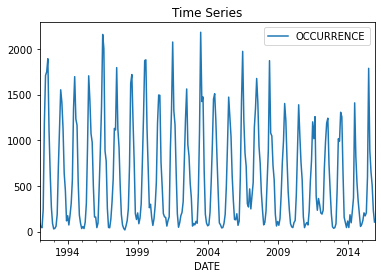

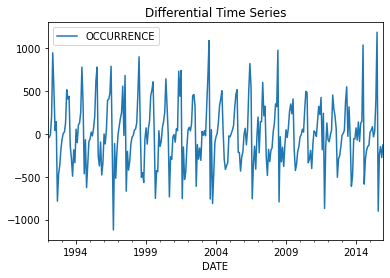

In [26]:
df_count = df_resample(df_fpaa, 'M', 'FIRE_NAME', "occurrence")

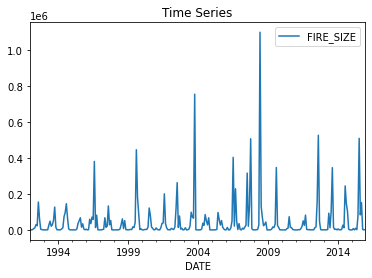

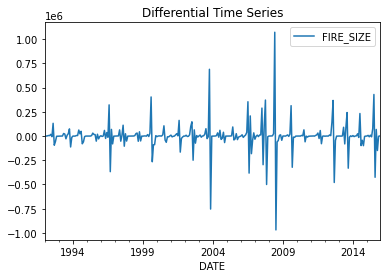

In [27]:
df_area = df_resample(df_fpaa, 'M', 'FIRE_SIZE', "area")

In [28]:
df_count['Year'] = df_count.index.year
df_count['Month'] = df_count.index.month

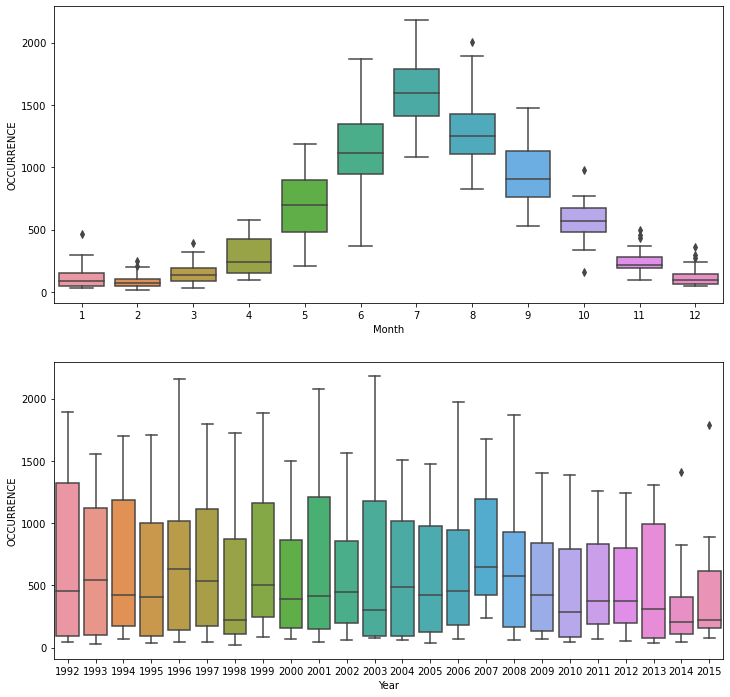

In [29]:
plot_monthly_annual(df_count,'OCCURRENCE')

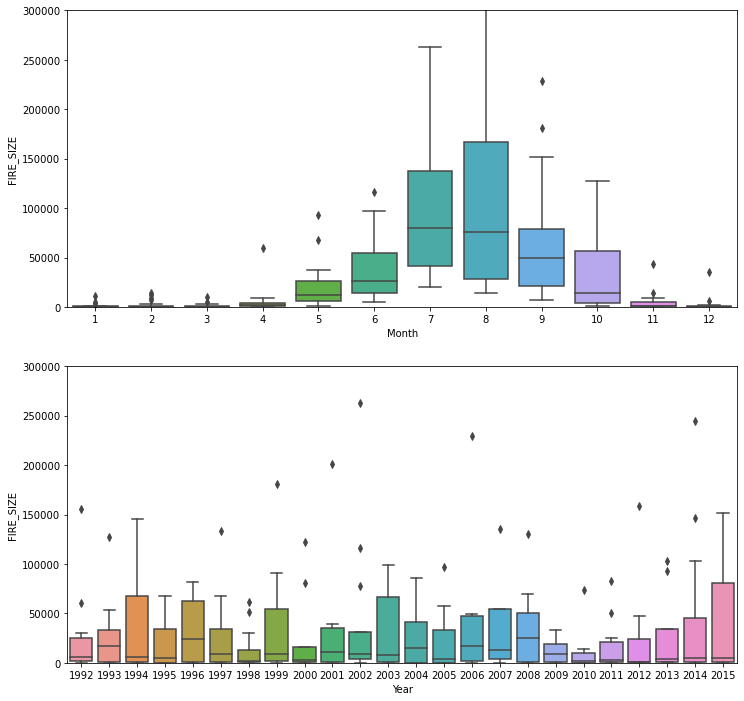

In [30]:
plot_monthly_annual(df_area, 'FIRE_SIZE')

Analysis: I'm not surprised that both wild fire occurrence and burn area are greatest in JJA (June-July-August) summer seasons when temperature is highest, and precipitation is lowest (in California's mediterranean climate). 

### PART 2. 
Q: Is there any trend in the wildfire frequency and severity (acres burned)? <br>
To analyze the trend of wildfire frequencty and severity, statistical analysis (e.g., ADF test) are used to determine if the time-series is stationary. Before we apply statistical test, it's usually good to plot the datasets and look at their trends.

In [31]:
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.seasonal import seasonal_decompose

In [32]:
def plot_ts(ts, plot_ma=True, plot_intervals=True, window=60, figsize=(15,5)):    
    """
    This function plot the moving average (rolling mean) of time serie and upper/lower bounds. 
    """
    rolling_mean = ts.rolling(window=window).mean()    
    rolling_std = ts.rolling(window=window).std()
    plt.figure(figsize=figsize)    
#    plt.title(ts.name) 
    plt.plot(ts[window:], label='Actual values', color="black")    
    if plot_ma:        
        plt.plot(rolling_mean, 'g', label='MA'+str(window),color="red")    
    if plot_intervals:
        lower_bound = rolling_mean - (1.96 * rolling_std)
        upper_bound = rolling_mean + (1.96 * rolling_std)
    plt.fill_between(x=ts.index, y1=lower_bound, y2=upper_bound,color='lightskyblue', alpha=0.4)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

In [33]:
def plot_seasonl_decompose(df, col, type="additive"):
    """
    This function run seasonal_decompose for specific type (by default is "additive") and plot the components 
    """
    result = seasonal_decompose(df[col], model=type)
    #print(result.trend)
    #print(result.seasonal)
    #print(result.resid)
    #print(result.observed)
    plot = result.plot()

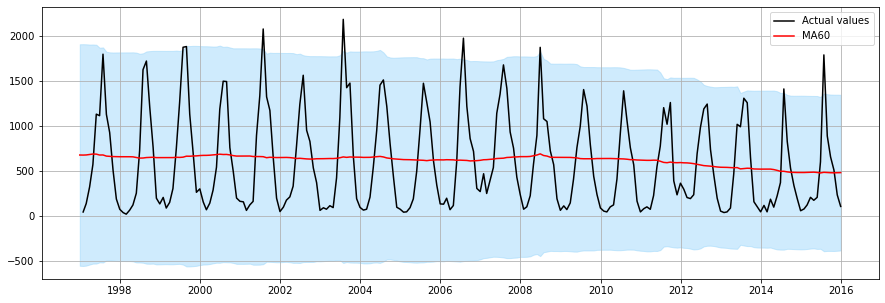

In [34]:
# 5-year moving average is plot here
plot_ts(df_count['OCCURRENCE'], window=60)

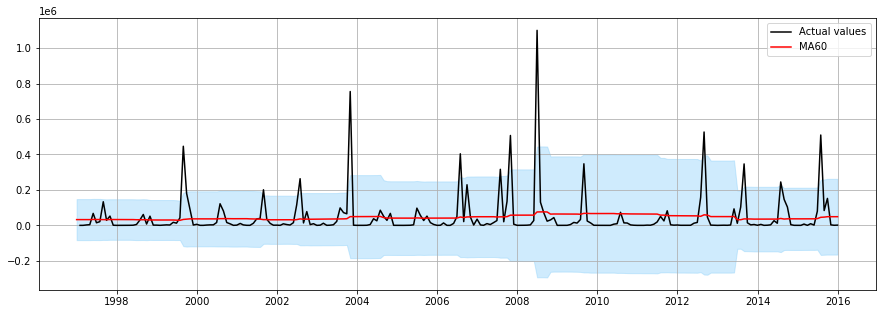

In [35]:
plot_ts(df_area['FIRE_SIZE'], window=60)

ADF test is the most commonly used test the Stationarity of the series, where the null hypothesis is the time series possesses a unit root and is non-stationary. So if the p-Value in ADH test is less than the significance level (0.05) we reject the null hypothesis. <br>
Null Hypothesis: The series has a unit root (Time series is not stationary).  <br>
Alternate Hypothesis: The series has no unit root (Time series is stationary).

In [36]:
def adf_test(timeseries):
    """
    This function compute the ADF statistics and determine if the time series is stationary. 
    """
#   result = adfuller(timeseries, autolag='AIC')
    result = adfuller(timeseries)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    
    if result[1] > 0.05:
        print('Series is not Stationary')
    else:
        print('Series is Stationary')

In [37]:
def kpss_test(timeseries):
    """
    This function compute the ADF statistics and determine if the time series is stationary. 
    """
#   result = adfuller(timeseries, autolag='AIC')
    statistic, p_value, n_lags, critical_values = kpss(timeseries)
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    
    if p_value < 0.05:
        print('Series is not Stationary')
    else:
        print('Series is Stationary')

In [38]:
adf_test(df_count['OCCURRENCE'])

ADF Statistic: -2.7794720297803397
p-value: 0.06126639918448515
Series is not Stationary


In [39]:
adf_test(df_area['FIRE_SIZE'])

ADF Statistic: -4.057558757711146
p-value: 0.001137363630097215
Series is Stationary


In [40]:
kpss_test(df_count['OCCURRENCE'])

KPSS Statistic: 0.3360219738373857
p-value: 0.1
Series is Stationary


/Users/zexuanxu/anaconda3/envs/geo_env/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/zexuanxu/anaconda3/envs/geo_env/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [41]:
kpss_test(df_area['FIRE_SIZE'])

KPSS Statistic: 0.2501755011724128
p-value: 0.1
Series is Stationary


/Users/zexuanxu/anaconda3/envs/geo_env/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [42]:
adf_test(np.sin(range(100)))

ADF Statistic: -1.3662109938001314e+16
p-value: 0.0
Series is Stationary


In [43]:
kpss_test(np.sin(range(100)))

KPSS Statistic: 0.38520666515351465
p-value: 0.08353160984762299
Series is Stationary


/Users/zexuanxu/anaconda3/envs/geo_env/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)


In [44]:
adf_test(np.sin(range(100)))

ADF Statistic: -1.3662109938001314e+16
p-value: 0.0
Series is Stationary


Analysis: The wildfire frequecy is not stationary, but burn area is stationary over the 1992-2015 period. Combining with the boxplot in the end of part 1, different period may behavior differently. For example, there is a increaing trend in burn area, but decreasing trend in occurrence. <br>
Note that a few outliers could significantly affects the results, however, we have limited information of outliers here so I tend to skip it for now. <br> 
In addition, the "Differential Time Series" in PART 2 clearly shows that both wildfire occurrence have strong seasonality thus it is not stationary, which has been demonstrated at the end of part 2 as well. 

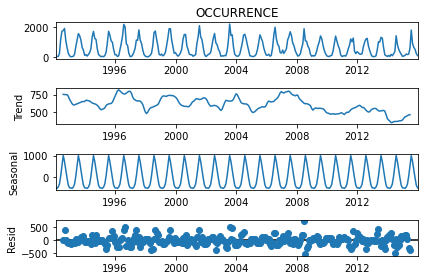

In [45]:
plot_seasonl_decompose(df_count, 'OCCURRENCE', type="additive")

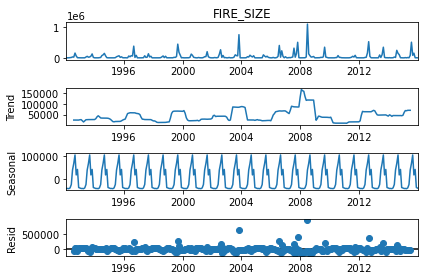

In [46]:
plot_seasonl_decompose(df_area, 'FIRE_SIZE', type="additive")

Analysis: Seasonal decomposition of monthly data indicates that there is no constant increasing or decreasing trends in both wildfire occurrence and fire size, however, the seasonalities are clearly shown. 

In addition, we also look at the annual data time series

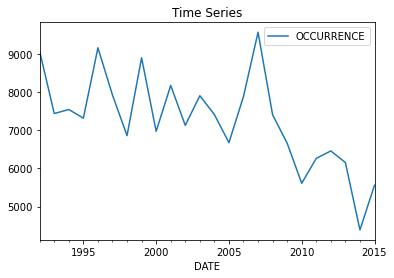

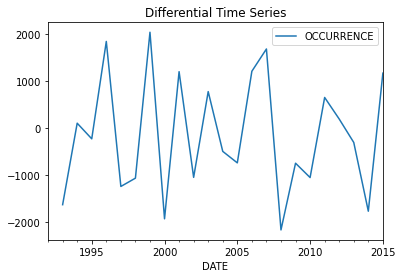

In [47]:
df_count_annual = df_resample(df_fpaa, 'Y', 'FIRE_NAME', "occurrence")

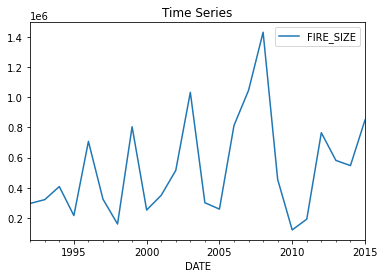

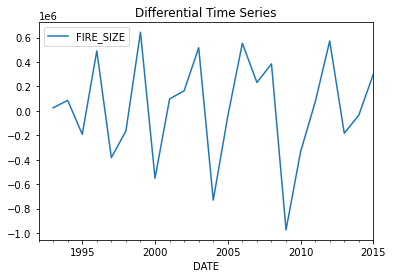

In [48]:
df_area_annual = df_resample(df_fpaa, 'Y', 'FIRE_SIZE', "area")

In [49]:
adf_test(df_count_annual['OCCURRENCE'])

ADF Statistic: -2.9022256244161655
p-value: 0.04508979909388246
Series is Stationary


In [50]:
kpss_test(df_count_annual['OCCURRENCE'])

KPSS Statistic: 0.3895570796638493
p-value: 0.08165643117937531
Series is Stationary


/Users/zexuanxu/anaconda3/envs/geo_env/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)


In [51]:
adf_test(df_area_annual['FIRE_SIZE'])

ADF Statistic: -1.681647960086653
p-value: 0.44059193853907025
Series is not Stationary


In [52]:
kpss_test(df_count_annual['OCCURRENCE'])

KPSS Statistic: 0.3895570796638493
p-value: 0.08165643117937531
Series is Stationary


/Users/zexuanxu/anaconda3/envs/geo_env/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)


If we can’t reject both test: data give not enough observations.

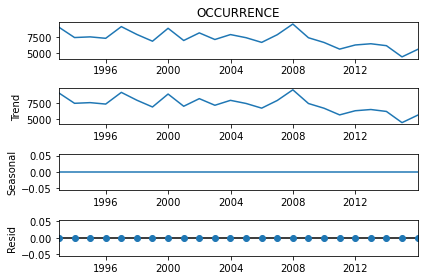

In [53]:
plot_seasonl_decompose(df_count_annual, 'OCCURRENCE', type="additive")

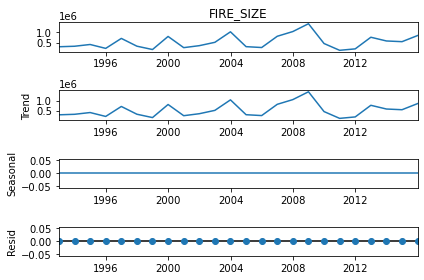

In [54]:
plot_seasonl_decompose(df_area_annual, 'FIRE_SIZE', type="additive")

Analysis: Not surprisely, there is no seasonality in the annual data. Interestingly, ADF test for monthly and annual time series show different results of stationarity for fire occurrence and burn area size. Due to time limit, we do not further discuss weak or strong stationarity here, or use different significane level or statistical tests to evaluate the stationarity and seasonality. 

### PART 3. 
Q: Is there any trend in climate? <br>
To answer this question, we aggragate the weather data within California to get a sense of "state-wide" climate trend. <br>
First, we examine the "Nan" values in each column, and use histgram plot to visualize the distribution of weather data. 


In [55]:
def weather_quality_check(df):
    """
    This function examine the "Nan" values in each column, and use histgram plot to visualize the distribution of weather data. 
    """
    print(df.isnull().sum())
    df.hist(figsize=(12,12), bins=25)

In [56]:
def weather_resample(df, frequency, cols):
    """
    This function subsets the weather datas, computes the spatial average over the study region (e.g., California), also fill nan/missing values by linear interpolation.  
    """
    df = df[cols]
    df_resampled = df.resample(frequency).mean()
    df_resampled = df_resampled.interpolate(method='linear')
    print(list(df_resampled.columns))
    print(df_resampled.describe())
    return df_resampled

In [57]:
def plot_weather_monthly(weather_monthly):
    """
    This function plot the time series of weather variables in the dataset.  
    """
    fig = plt.figure(figsize=(15,10))

    for i in range(len(weather_monthly.columns)): 
        ax = fig.add_subplot(3,4,i+1)
        ax.plot(weather_monthly.iloc[:,i])
        ax.set_ylabel(weather_monthly.columns[i])
    fig.tight_layout()
    fig.savefig("./Plots/weather_variables.png")

Lat            0
Lon            0
month          0
AWND           0
DAPR      568890
EVAP       74970
MDPR      427770
MNPN      264600
MXPN      264600
PGTM      105840
PRCP           0
SNOW           0
SNWD           0
TAVG           0
TMAX           0
TMIN           0
TOBS           0
WDFG     1023120
WDMV      255780
WESD           0
WSFG     1023120
WT01           0
WT02           0
WT03           0
WT04           0
WT05           0
WT06           0
WT07           0
WT08           0
WT10      158760
WT11           0
WT14      105840
WT16      105840
WT18      105840
WT22      317520
yymm           0
WT17      370440
WT19      158760
WT13      317520
WT21      317520
WV01      740880
WV03      899640
WV20      793800
FMTM      546840
WDF2      330750
WDF5      330750
WSF2      330750
WSF5      330750
TSUN     1014300
DASF     1265670
MDSF     1248030
dtype: int64


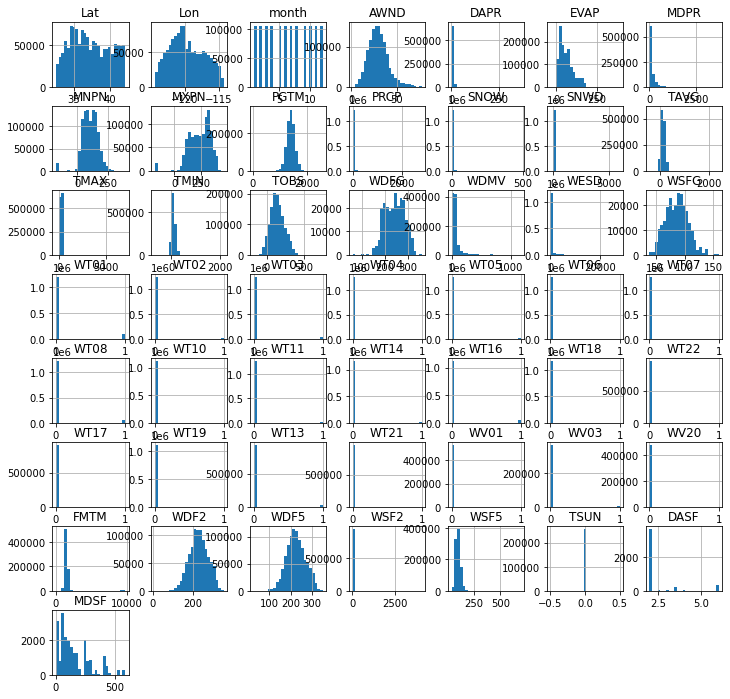

In [58]:
weather_quality_check(weather)

Based on the histogram, we do not include those variables with small variance in the analysis and model development in the next part. We also exclude some variables based on the number of missing values, and domain knowledges. <br>
We do not include most variables with missing data, except "EVAP" (evaporation) because I think this is an important indicator for analyzing wildfire. A linear interpolation filling is used (although this is not the best way to analyze its trend). <br>

In [59]:
weather_monthly = weather_resample(weather, 'M', ['AWND','EVAP','MNPN','MXPN','PRCP','SNOW','SNWD','TAVG','TMAX','TMIN','TOBS','WESD'])

['AWND', 'EVAP', 'MNPN', 'MXPN', 'PRCP', 'SNOW', 'SNWD', 'TAVG', 'TMAX', 'TMIN', 'TOBS', 'WESD']
             AWND        EVAP        MNPN        MXPN        PRCP        SNOW  \
count  288.000000  288.000000  288.000000  288.000000  288.000000  288.000000   
mean    29.919383   61.543353  103.849670  236.465459   16.770997    1.573167   
std      4.966378   33.876201   49.437764   78.969205   18.417370    2.598791   
min     17.608297   13.021584  -34.519775   54.983868    0.081903    0.000000   
25%     26.189515   28.068289   64.117127  167.339693    2.741575    0.000103   
50%     29.712819   58.001241  103.106603  240.008761    9.751113    0.462995   
75%     33.894608   93.008549  146.361089  305.944144   23.575808    2.178153   
max     43.721808  122.713309  204.352995  366.543912   98.791726   20.489667   

             SNWD        TAVG        TMAX        TMIN        TOBS         WESD  
count  288.000000  288.000000  288.000000  288.000000  288.000000   288.000000  
mean    22.

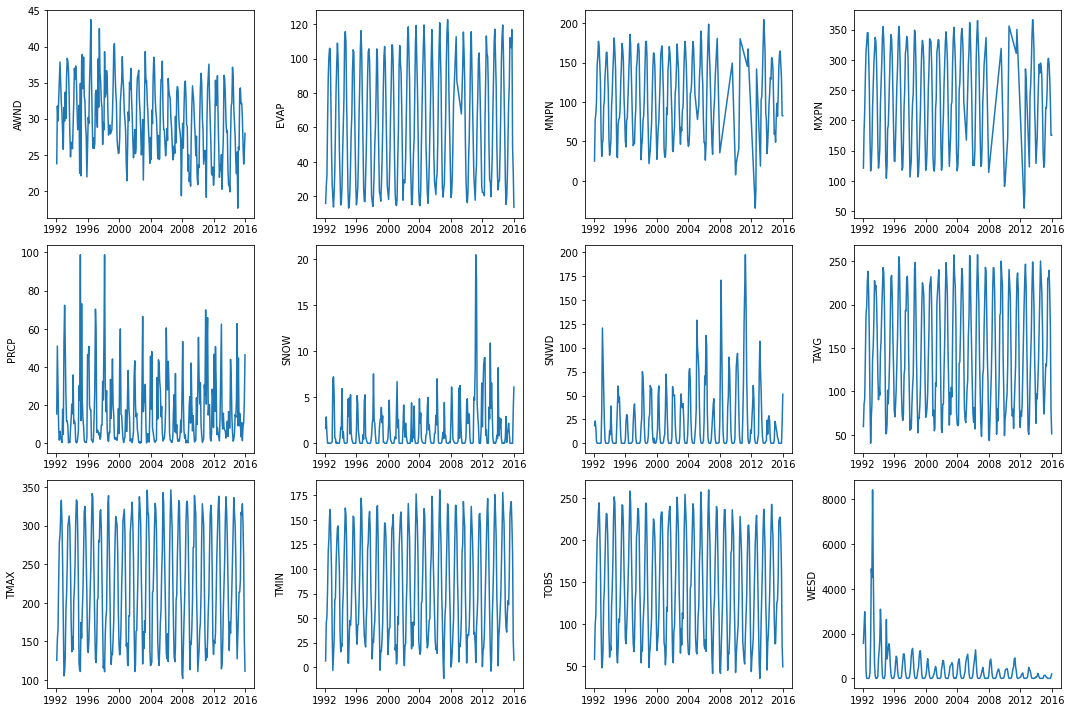

In [60]:
plot_weather_monthly(weather_monthly)

In [61]:
for i in range(12):
    print(str(weather_monthly.columns[i]))
    adf_test(weather_monthly.iloc[:,i])

AWND
ADF Statistic: -1.3190449646454876
p-value: 0.6204148072262818
Series is not Stationary
EVAP
ADF Statistic: -3.521858230639961
p-value: 0.007443156426054071
Series is Stationary
MNPN
ADF Statistic: -6.7801815643537156
p-value: 2.511041811472465e-09
Series is Stationary
MXPN
ADF Statistic: -7.247589140869063
p-value: 1.815136381412176e-10
Series is Stationary
PRCP
ADF Statistic: -3.4568841273235464
p-value: 0.009165954896293432
Series is Stationary
SNOW
ADF Statistic: -2.5198030781967415
p-value: 0.1107300682455214
Series is not Stationary
SNWD
ADF Statistic: -3.3400296425777434
p-value: 0.01318125630421469
Series is Stationary
TAVG
ADF Statistic: -3.458361624435557
p-value: 0.00912310785517737
Series is Stationary
TMAX
ADF Statistic: -3.4765403378097477
p-value: 0.008610429119934404
Series is Stationary
TMIN
ADF Statistic: -2.8227939700347506
p-value: 0.055090855583215075
Series is not Stationary
TOBS
ADF Statistic: -2.2486316516655416
p-value: 0.18907051037618094
Series is not St

In [62]:
for i in range(12):
    print(str(weather_monthly.columns[i]))
    kpss_test(weather_monthly.iloc[:,i])

AWND
KPSS Statistic: 1.2367034425767098
p-value: 0.01
Series is not Stationary
EVAP
KPSS Statistic: 0.20853733998563256
p-value: 0.1
Series is Stationary
MNPN
KPSS Statistic: 0.03449304495847478
p-value: 0.1
Series is Stationary
MXPN
KPSS Statistic: 0.03504224586120013
p-value: 0.1
Series is Stationary
PRCP
KPSS Statistic: 0.07123759094500749
p-value: 0.1
Series is Stationary
SNOW
KPSS Statistic: 0.3503392796711004
p-value: 0.09856065531418086
Series is Stationary
SNWD
KPSS Statistic: 0.33902443687238576
p-value: 0.1
Series is Stationary
TAVG
KPSS Statistic: 0.03307539796861609
p-value: 0.1
Series is Stationary
TMAX
KPSS Statistic: 0.045256036169975096
p-value: 0.1
Series is Stationary
TMIN
KPSS Statistic: 0.05629555386777702
p-value: 0.1
Series is Stationary
TOBS
KPSS Statistic: 0.1558188681813323
p-value: 0.1
Series is Stationary
WESD
KPSS Statistic: 0.8852114161856532
p-value: 0.01
Series is not Stationary


/Users/zexuanxu/anaconda3/envs/geo_env/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/zexuanxu/anaconda3/envs/geo_env/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/Users/zexuanxu/anaconda3/envs/geo_env/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actua

In summary, ADF test indicates that windspeed, snowfall, Tmin and TOBS are not stationary, while others are stationary.

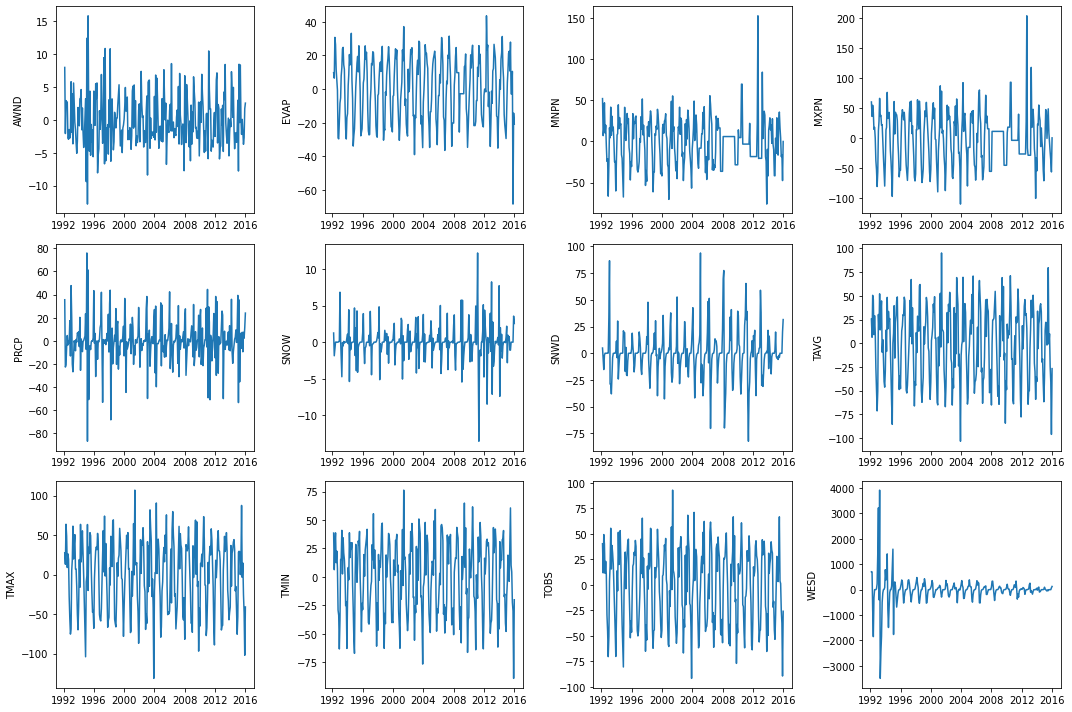

In [63]:
plot_weather_monthly(weather_monthly.diff())

The plots of differential time series of weather data show that most of weather variables have seasonality.

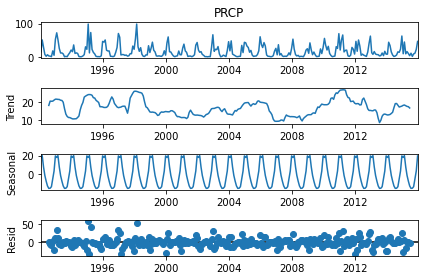

In [64]:
plot_seasonl_decompose(weather_monthly, 'PRCP', type="additive")

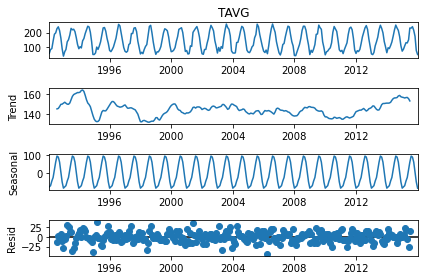

In [65]:
plot_seasonl_decompose(weather_monthly, 'TAVG', type="additive")

Analysis: The seasonal decomposition results for two "most impoortant" weather variables (precipitation and temperature) are shown here. As we observed, there is no constant increasing or decreasing trends in both wildfire occurrence and fire size, however, the seasonalities are clearly shown. 

In [66]:
weather_annual = weather_resample(weather, 'Y', ['AWND','EVAP','MNPN','MXPN','PRCP','SNOW','SNWD','TAVG','TMAX','TMIN','TOBS','WESD'])

['AWND', 'EVAP', 'MNPN', 'MXPN', 'PRCP', 'SNOW', 'SNWD', 'TAVG', 'TMAX', 'TMIN', 'TOBS', 'WESD']
            AWND       EVAP        MNPN        MXPN       PRCP       SNOW  \
count  24.000000  24.000000   24.000000   24.000000  24.000000  24.000000   
mean   29.919383  61.280065  103.353792  236.280704  16.770997   1.573167   
std     1.649964   4.694868   18.605076   28.011179   4.689503   1.103963   
min    27.323223  52.180087   54.332352  172.480505   8.691332   0.770891   
25%    28.322686  58.315265   98.321360  227.004805  13.760097   1.014739   
50%    30.135722  60.584678  104.486070  237.687649  15.858273   1.290412   
75%    31.301542  63.972732  108.861595  242.332436  20.029792   1.520312   
max    33.061095  71.286016  156.254814  330.667759  24.748605   5.473048   

            SNWD        TAVG        TMAX       TMIN        TOBS         WESD  
count  24.000000   24.000000   24.000000  24.000000   24.000000    24.000000  
mean   22.785330  144.630988  222.642766  80.960378

In [67]:
for i in range(12):
    print(str(weather_annual.columns[i]))
    adf_test(weather_annual.iloc[:,i])

AWND
ADF Statistic: -6.604470809618661
p-value: 6.6096249251238125e-09
Series is Stationary
EVAP
ADF Statistic: -1.7222625321491563
p-value: 0.4196801873279893
Series is not Stationary
MNPN
ADF Statistic: -6.506251367396533
p-value: 1.1292656429604847e-08
Series is Stationary
MXPN
ADF Statistic: -1.8724590737506022
p-value: 0.34512605276882097
Series is not Stationary
PRCP
ADF Statistic: -4.930830408286339
p-value: 3.0362562771911495e-05
Series is Stationary
SNOW
ADF Statistic: -1.0648735453146654
p-value: 0.7288747939679865
Series is not Stationary
SNWD
ADF Statistic: -2.471335540892756
p-value: 0.12260536645645914
Series is not Stationary
TAVG
ADF Statistic: -2.7679401952526703
p-value: 0.06300121912817086
Series is not Stationary
TMAX
ADF Statistic: -3.0135305400315486
p-value: 0.033649993365671566
Series is Stationary
TMIN
ADF Statistic: -6.043516066632146
p-value: 1.328548453232235e-07
Series is Stationary
TOBS
ADF Statistic: -2.0759407270809453
p-value: 0.25429834062247225
Series

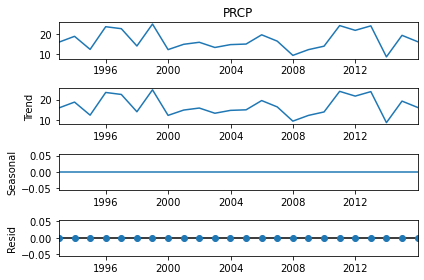

In [68]:
plot_seasonl_decompose(weather_annual, 'PRCP', type="additive")

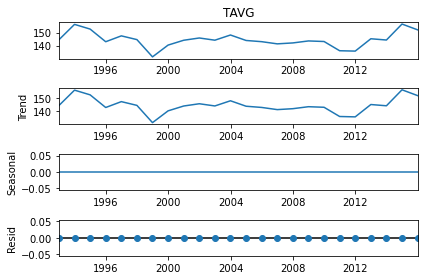

In [69]:
plot_seasonl_decompose(weather_annual, 'TAVG', type="additive")

Analysis: Similar to the wildfire datasets, monthly and annual data show different stationarity. 

### PART 4.
Q: What are the major factors affecting frequency and severity of wildfires? <br>
We compute the Pearson correlation between weather variables and frequency/severity of wildfire. Correlation measures how strongly two variables are related <br>
Of course, "correlation does not imply causation". And we need to gather additional information to determine the major factors affecting wildfire, which is beyond the scope of this data challenge. Here we only discuss the major controlling weather factors affecting wildfile. 

In [70]:
from numpy import cov
from scipy.stats import pearsonr

In [71]:
def plot_weather_fire(weather_monthly, df, col):
    """
    This function plot occurrences/burn area vs. weather variables. Each point represents the aggragated occurrence or burn area of wildfire in one month.   
    """
    fig = plt.figure(figsize=(15,10))

    for i in range(12): 
        ax = fig.add_subplot(3,4,i+1)
        plt.scatter(weather_monthly.iloc[:,i],df[col])
        ax.set_ylabel(col)
        ax.set_xlabel(weather_monthly.columns[i])
    fig.tight_layout() 
    fig.savefig("./Plots/"+col+"_weather.png")

In [72]:
def compute_pearsonr(weather_monthly, df, col):
    """
    This function computes the pearson correlation between occurrence/burn area vs. weather variables.   
    """
    for i in range(12):
        corr, _ = pearsonr(weather_monthly.iloc[:,i],df[col])
        print('Pearsons correlation between '+col+ ' and '+ weather_monthly.columns[i]+' : %.3f' % corr)

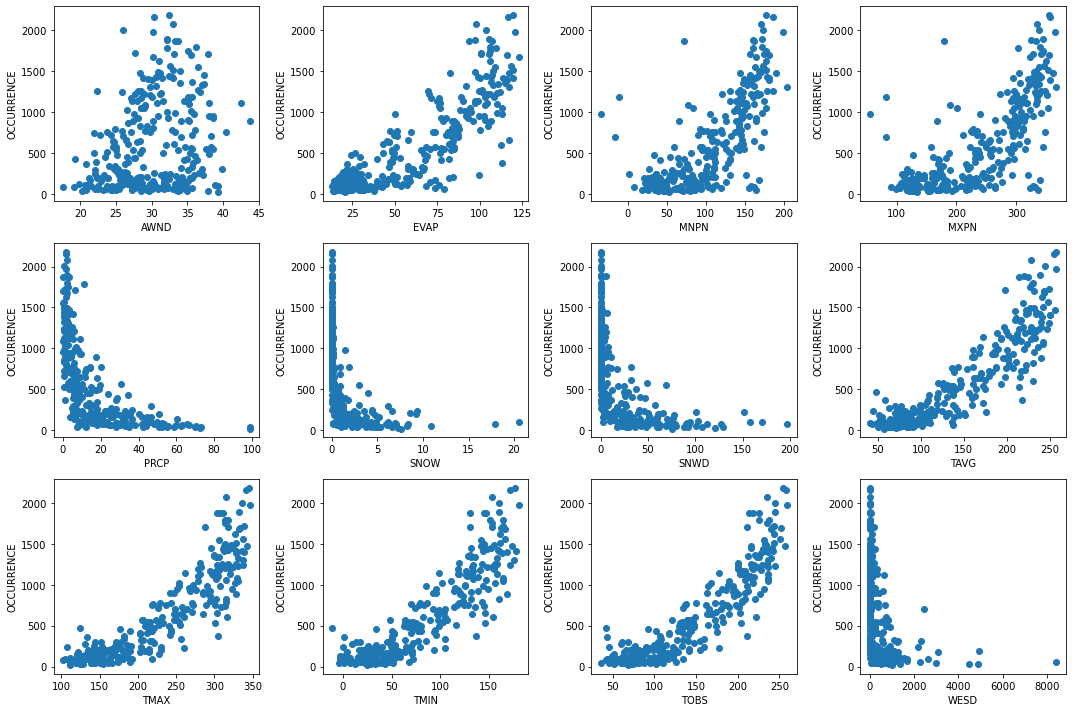

In [73]:
plot_weather_fire(weather_monthly,df_count,'OCCURRENCE')

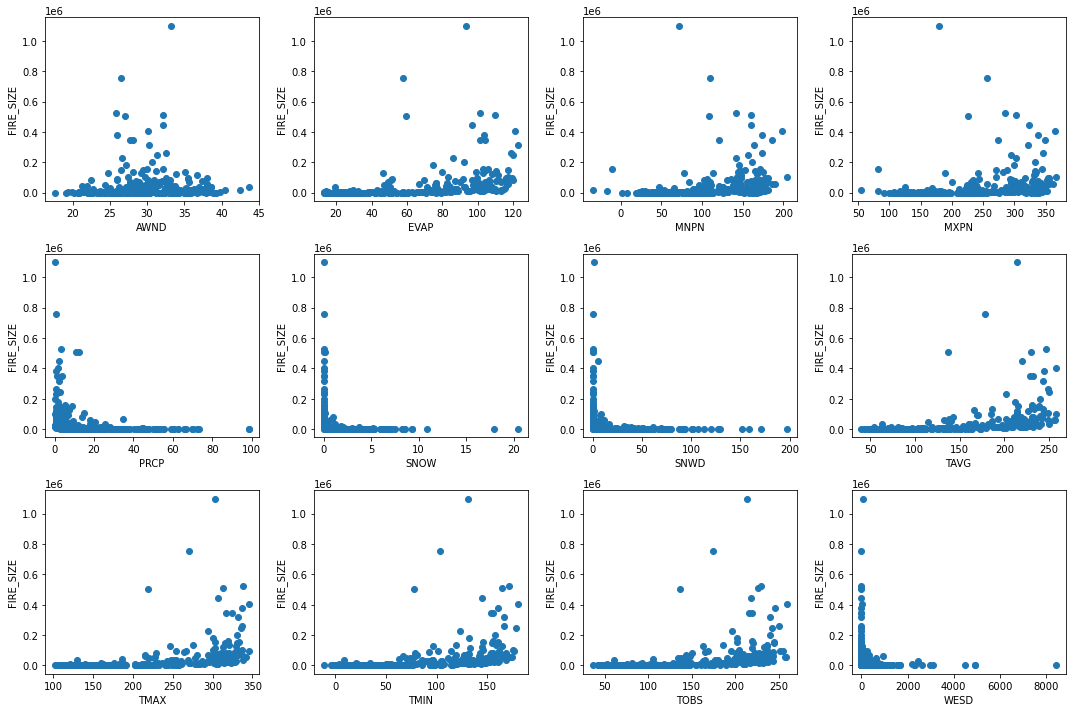

In [74]:
plot_weather_fire(weather_monthly,df_area,'FIRE_SIZE')

In [75]:
compute_pearsonr(weather_monthly, df_count, 'OCCURRENCE')

Pearsons correlation between OCCURRENCE and AWND : 0.284
Pearsons correlation between OCCURRENCE and EVAP : 0.843
Pearsons correlation between OCCURRENCE and MNPN : 0.730
Pearsons correlation between OCCURRENCE and MXPN : 0.728
Pearsons correlation between OCCURRENCE and PRCP : -0.632
Pearsons correlation between OCCURRENCE and SNOW : -0.515
Pearsons correlation between OCCURRENCE and SNWD : -0.555
Pearsons correlation between OCCURRENCE and TAVG : 0.891
Pearsons correlation between OCCURRENCE and TMAX : 0.889
Pearsons correlation between OCCURRENCE and TMIN : 0.885
Pearsons correlation between OCCURRENCE and TOBS : 0.899
Pearsons correlation between OCCURRENCE and WESD : -0.357


In [76]:
compute_pearsonr(weather_monthly, df_area, 'FIRE_SIZE')

Pearsons correlation between FIRE_SIZE and AWND : 0.018
Pearsons correlation between FIRE_SIZE and EVAP : 0.369
Pearsons correlation between FIRE_SIZE and MNPN : 0.268
Pearsons correlation between FIRE_SIZE and MXPN : 0.243
Pearsons correlation between FIRE_SIZE and PRCP : -0.275
Pearsons correlation between FIRE_SIZE and SNOW : -0.229
Pearsons correlation between FIRE_SIZE and SNWD : -0.253
Pearsons correlation between FIRE_SIZE and TAVG : 0.417
Pearsons correlation between FIRE_SIZE and TMAX : 0.417
Pearsons correlation between FIRE_SIZE and TMIN : 0.420
Pearsons correlation between FIRE_SIZE and TOBS : 0.405
Pearsons correlation between FIRE_SIZE and WESD : -0.176


Analysis: From Pearson correlation, wildfire occurrence and severity (fire size) has strong postive correlation with temperatures (TAVG, TMAX, TMIN, TOBS), mild positive correlation with wind speed and evaporation, and negative correlation with precipitation and snow variables. <br>
The statistic makes sense to me because domain knowledges tells us the possibility of wildfire is higher with warmer temperatur and less precipitation. It's somehow surprised me that the correlation of windspeed is not strong. 

### PART 5.
Q: Can you build models that predicts annual/monthly (1) frequency wildfires, (2) severity of wildfires (by acres burned)? <br>

A few key assumptions and precedures in the model developements are summarized here: <br>
1) A random forest model is used for developing model here. Random forest is one of the most widely used machine learning models, because it can run parallel, requires little data preprocessing work without the need to rescaling or reformatting. It handles non-linear parameter, and presents estimates for variable importance. It’s also robust to outlier data and has low bias. <br>
2) We do not use time series model (e.g., ARIMA) for this study because they are basically a univariate based model without considering the affecting factors (e.g, weather). We do not use deep learning (including recurrent neural network, e.g., LSTM) because the deep learning model usually takes longer to train, can be hard to interpret the results as a black box, and does not usually outperform random forest.  <br>
3) A forward chaining time series split is used in cross validation, because we are simulating time series and our observations are not independent, thus we usually can't split data randomly using k-fold cross validation.  <br>
4) The time-series is aggregated at monthly frequency because the temporal resolution of weather data is monthly.  <br>
5) The weather and wildfire data are aggregrated at 1-degree spatial resolution (to the nearest round number) in order to reduce the time of training for this data challenge. Idealy, we can build the model at 0.1-degree resolution as the spatial resolution of weather data.   <br>
6) Some outlier detection is needed here, for example, Temperature >= 600 (unit is tenths of degree C). However, we skip this for now due to the time limit.   <br>
7) Only six predictors (['AWND','EVAP','PRCP','SNOW','TAVG','WESD']) are used in the model. They are selected based on the statistics and histogram of weather variables (the low-variance features are not used), and domain knowledges.  
8) Two hyperparameter search and cross validation schemes are implemented. One is randomizedsearch, which sets up a grid of hyperparameter values and selects random combinations to train the model and score. The other one is gridsearch, which sets up a grid of hyperparameter values and for each combination, trains a model and scores on the testing data. Usually, we do a randomizedsearch over wider ranges of hyperparameters, then we do a gridsearch based on the results from randomizedsearch. 


In [58]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,TimeSeriesSplit,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
import pickle

In [59]:
def preprocess_weather(weather, col):
    """
    This function preprocesses weather data. 
    Two additional columns of round-number latitude and longitude are computed for merging purpose later.
    This function also fill missing EVAP data by linear interpolation, and check the quality of weather dataset. 
    """
    weather['Lat0'] = weather['Lat'].round(0)
    weather['Lon0'] = weather['Lon'].round(0)
    weather = weather[col]
    weather['EVAP'] = weather['EVAP'].interpolate(method='linear')
    weather_quality_check(weather)
    print(list(weather.columns))
    print(weather.describe())
    return weather

In [60]:
def preprocess_fire(df, col):
    """
    This function preprocesses the wildfire data. 
    Two additional columns of round-number latitude and longitude are computed for merging purpose later.
    This function also check the quality of weather dataset. 
    """
    df['Lat0'] = df['LATITUDE'].round(0)
    df['Lon0'] = df['LONGITUDE'].round(0)
    df['yymm'] = df['DISCOVERY_DATE'].dt.to_period('M')
    df = df[col]
    print(df.isnull().sum())
    print(list(df.columns))
    print(df.describe())
    df.hist(bins=25)
    return df

In [61]:
def preprocess_for_model(weather, df, type, col):
    """
    This function merged the weather data and wildfire data, and aggregate them to 1-degree resolution to reduce the number of datapoints used for model development
    Occurrence ("frequency") is group by count, and burn area ("severity") is group by sum. 
    Datasets are sorted sequentially, and output preditors (X) and target (y) variables. 
    """    
    new_df = pd.merge(weather, df,  how='left', left_on=['Lat0','Lon0','yymm'], right_on = ['Lat0','Lon0','yymm'])
    if type == "frequency":
        new_df1 = new_df[['Lat0','Lon0','yymm','FPA_ID']].groupby(['Lat0','Lon0','yymm']).count().reset_index()
    elif type == "severity":
        new_df1 = new_df[['Lat0','Lon0','yymm','FIRE_SIZE']].groupby(['Lat0','Lon0','yymm']).sum().reset_index()
    new_df2 = new_df[col].groupby(['Lat0','Lon0','yymm']).mean().reset_index()
    new_df1 = new_df1.sort_values(by=['yymm'])
    new_df2 = new_df2.sort_values(by=['yymm'])

    new_df1.hist(bins=25)
    new_df2.hist(bins=25)
    
    y = new_df1.values[:,3:]
    X = new_df2.values[:,3:]
    index_df = new_df1[['Lat0', 'Lon0', 'yymm']]
    return X, y, index_df

In [62]:
def print_statistics(train_true, train_pred, test_true, test_pred):
    """
    Print statistics of both training and testing results to evaluate model performance
    """    
    print('Train')
    print('MAE:', mean_absolute_error(train_true, train_pred))
    print('MSE:', mean_squared_error(train_true, train_pred))
    print('R2:', r2_score(train_true, train_pred))

    print('\nTest')
    print('MAE:', mean_absolute_error(test_true, test_pred))
    print('MSE:', mean_squared_error(test_true, test_pred))
    print('R2:', r2_score(test_true, test_pred))

In [63]:
def model_train_test(X_train, y_train, type, grid, num, model_filename):
    """
    This function set up a randomforestregressor, and used timeseriessplit for cross validation
    Hyperparameter search for GridSearch or RandomizedSearch
    return the best random forest model, and save the model file in case we need to load the pre-trained model
    """
    model = RandomForestRegressor(criterion='mse', verbose=1)

    tscv = TimeSeriesSplit(n_splits=num)
    
    if type == "GridSearch":
        RFR_CV = GridSearchCV(estimator=model, cv=tscv, param_grid=grid, verbose=1)
    elif type == "RandomizedSearch":
        # n_iter = 10 is too smaller to make sense in actually simulation - just use a smaller number here due to time limit.
        RFR_CV = RandomizedSearchCV(estimator=model, cv=tscv, param_distributions = random_grid, verbose=1, random_state=42, n_iter = 10)

    RFR_CV.fit(X_train, y_train)
    
    print(RFR_CV.best_params_)
    best_RFR = RFR_CV.best_estimator_
    
    pickle.dump(best_RFR, open(model_filename, 'wb'))
    
    return best_RFR

In [64]:
def model_feature_importances(myRFR, feature_list):
    """
    This function gets numerical feature importances of random forest model output  
    """
    importances = list(myRFR.feature_importances_)
    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # Print out the feature and importances 
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];
    
    return feature_importances

In [65]:
def model_visualization(y_train, pred_train, y_test, pred_test, df, target):
    """
    This function plots the data and prediction results in train and test parts   
    """    
    split = len(y_train)
    y = np.concatenate((y_train, y_test)).astype(float)
    pred = np.concatenate((pred_train, pred_test))
    
    df['data'] = y
    df['pred'] = pred
    print(df.head())

    df = df.set_index('yymm').to_timestamp()

    df_monthly = df.resample('M').mean()
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)
    ax.plot(df_monthly['data'], label='data')
    ax.plot(df_monthly['pred'], label='prediction')
    ax.axvline(x=df_monthly.index[239], color='red')
    ax.text(df_monthly.index[240], 0, 'test')
    ax.text(df_monthly.index[220], 0, 'training')

    ax.legend()
    fig.savefig("./Plots/Train_test_"+target+".png")

In [66]:
def run_model(task, model_filename, target, predictors, grid):
    """
    This function runs the whole model development procedure    
    """      
    weather1 = preprocess_weather(weather, ['Lat0','Lon0','yymm','AWND','EVAP','PRCP','SNOW','SNWD','TAVG','TMAX','TMIN','TOBS','WESD'])
    df_fpaa1 = preprocess_fire(df_fpaa, ['Lat0','Lon0','yymm','FIRE_SIZE','FPA_ID'])
    X, y, index_df = preprocess_for_model(weather1, df_fpaa1, target, ['Lat0','Lon0','yymm']+predictors)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1667, shuffle=False)

    if task == "gridsearch_model":
        my_model = model_train_test(X_train, y_train, "GridSearch", grid, 5, model_filename)
    elif task == "randomsearch_model":
        my_model = model_train_test(X_train, y_train, "RandomizedSearch", grid, 5, model_filename)
    elif task == "load_model":
        my_model = pickle.load(open(model_filename, 'rb'))
    else:
        print("Unsupported task")
        
    feature_importances = model_feature_importances(my_model, predictors)

    pred_train = my_model.predict(X_train)
    pred_test = my_model.predict(X_test)
    print_statistics(y_train, pred_train, y_test, pred_test)
    
    model_visualization(y_train, pred_train, y_test, pred_test, index_df, target)

I used the hyperparameter grids from my previous study, which are not been carefully evaluated for this data challenge.

In [67]:
# RandomizedSearch hyperparameter grid - this is from one of my previous study
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [68]:
# GridSearch hyperparameter grid - this is from one of my previous study
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300]
}

Here we can run the model by specifying the hyperparameter search task and target variables. Depending on the setup and computational environment, the model training can take a few minutes or hours. 

<ipython-input-59-35f4101345e7>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather['EVAP'] = weather['EVAP'].interpolate(method='linear')


Lat0    0
Lon0    0
yymm    0
AWND    0
EVAP    0
PRCP    0
SNOW    0
SNWD    0
TAVG    0
TMAX    0
TMIN    0
TOBS    0
WESD    0
dtype: int64
['Lat0', 'Lon0', 'yymm', 'AWND', 'EVAP', 'PRCP', 'SNOW', 'SNWD', 'TAVG', 'TMAX', 'TMIN', 'TOBS', 'WESD']
               Lat0          Lon0          AWND          EVAP          PRCP  \
count  1.270080e+06  1.270080e+06  1.270080e+06  1.270080e+06  1.270080e+06   
mean   3.725850e+01 -1.196494e+02  2.991938e+01  6.058349e+01  1.677100e+01   
std    2.613038e+00  2.535465e+00  1.103480e+01  4.253596e+01  3.508761e+01   
min    3.300000e+01 -1.240000e+02  1.666667e+00 -3.616667e+01  0.000000e+00   
25%    3.500000e+01 -1.220000e+02  2.241935e+01  2.600000e+01  0.000000e+00   
50%    3.700000e+01 -1.200000e+02  2.906452e+01  5.300000e+01  3.709677e+00   
75%    4.000000e+01 -1.180000e+02  3.593548e+01  8.123333e+01  1.746667e+01   
max    4.200000e+01 -1.140000e+02  7.751613e+01  3.922000e+02  2.817000e+03   

               SNOW          SNWD       

/Users/zexuanxu/anaconda3/envs/geo_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
/Users/zexuanxu/anaconda3/envs/geo_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurren

[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:   24.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.2s finished
/Users/zexuanxu/anaconda3/envs/geo_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:   31.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.3s finished
/Users/zexuanxu/anaconda3/envs/geo_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    4.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.1s finished
/Users/zexuanxu/anaconda3/envs/geo_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    5.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.1s finished
/Users/zexuanxu/anaconda3/envs/geo_env/lib/python3.9/site-packages/sklearn/model_s

[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    0.3s finished
/Users/zexuanxu/anaconda3/envs/geo_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:   12.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    0.3s finished
/Users/zexuanxu/anaconda3/envs/geo_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_pa

{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}
Variable: TAVG                 Importance: 0.38
Variable: EVAP                 Importance: 0.26
Variable: AWND                 Importance: 0.16
Variable: PRCP                 Importance: 0.11
Variable: SNOW                 Importance: 0.04
Variable: WESD                 Importance: 0.04


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


Train
MAE: 794.9558997468889
MSE: 2292809.6561991093
R2: 0.4303042819977698

Test
MAE: 934.0898407704861
MSE: 2141587.598196254
R2: 0.20429047886320706
       Lat0   Lon0     yymm   data        pred
0      33.0 -120.0  1992-01    0.0  131.929278
288    33.0 -119.0  1992-01    0.0  206.922484
7200   36.0 -119.0  1992-01    0.0  221.467498
3168   34.0 -116.0  1992-01  847.0  468.776673
14976  40.0 -120.0  1992-01    0.0   92.867562


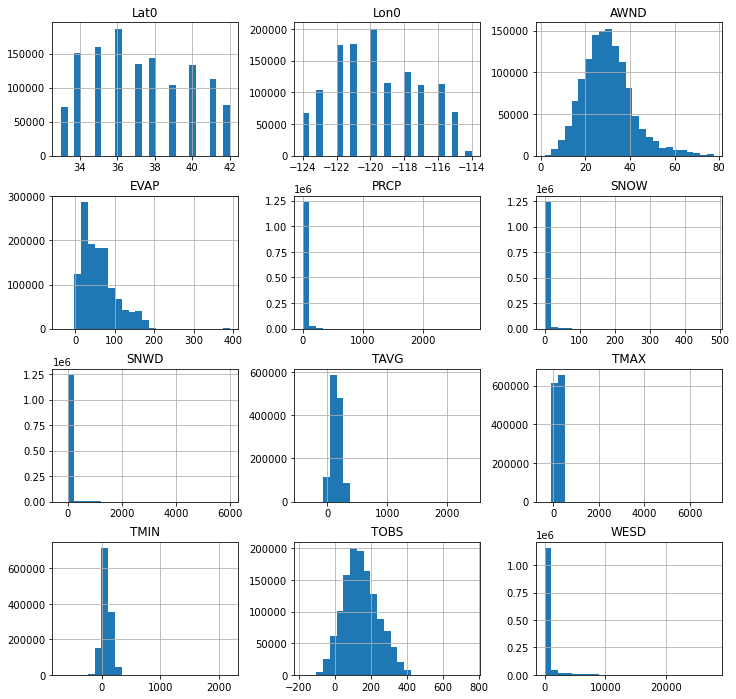

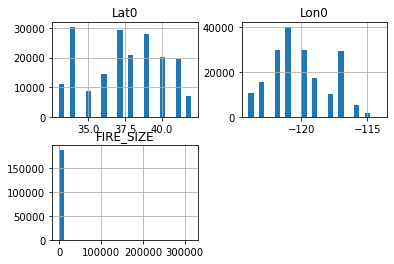

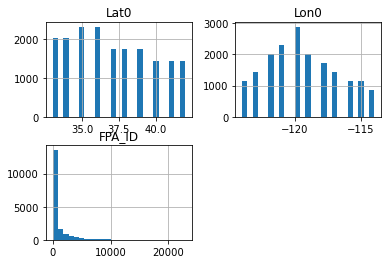

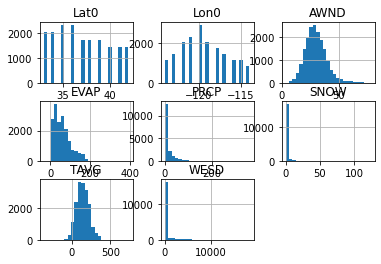

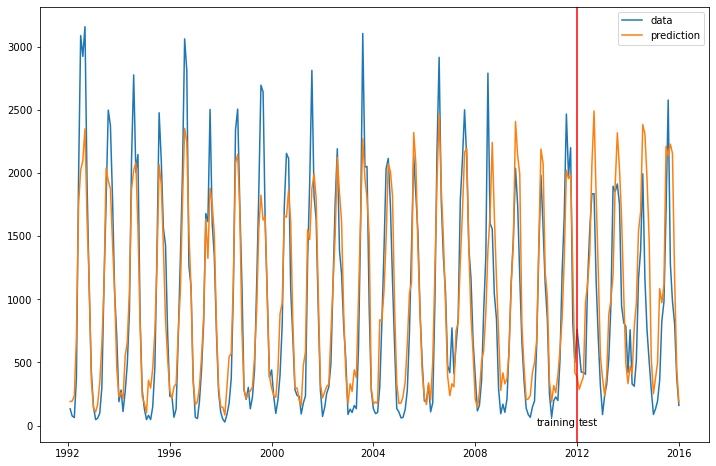

In [70]:
task = "randomsearch_model" # It could be "gridsearch_model", "randomsearch_model", or "load_model". 
#"gridsearch_model”: Use GridSearchCV for model optimization
#“randomsearch_model": Use RandomizedSearchCV for model optimization
#"load_model": Load a saved scikit-learn model file
model_filename = "RF_RandomizedSearchCV.sav"  # or RF_RandomizedSearchCV
target = 'frequency'  # It could be "frequency" or "severity"
#"frequency" (to predict the monthlytotal occurrences of wildfire in California)
#"severity" (to predict the monthly total burned area in California) 
predictors=['AWND','EVAP','PRCP','SNOW','TAVG','WESD']
# random_grid (for RandomizedSearchCV) or param_grid (for GridSearchCV)

run_model(task, model_filename, target, predictors, random_grid)

Analysis:
1) We might overfit the model as the test error is greater than train error. <br>
2) The hyperparameters and features have not being fine-tuned thus the results are not satisfactory. The parameter distribution used in RandomizedSearchCV and parameter grid in GridSearchCV are not optimal.  <br>
3) The aggregated dataset we used for model development is imbalanced as most grid points have 0 occurrence and 0 burn area - this causes significant error in the model.

Further work with additional time: <br>
1) Compare the temporal and spatial wildfire information in the FPA database file and shapefiles. The analysis we use either the FPA dataset for temporal analysis, or shapefiles for spatial analysis.  <br>
2) Think more carefully about the features and models used to develop predictivity, e.g., resample the datasets, and select different models for comparison.  <br>
3) Aggregate the model at finer resolution (e.g., 0.1-degree) with far more datapoints used in model development. 
